# Cleaning and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import sys
sys.path.insert(0, '/Users/coconut/Desktop/zach/GA/Submissions/')
import eda

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12.0, 9.0)

In [4]:
# Read dataset
train = pd.read_csv('../datasets/train.csv')

---

In [5]:
# Id and PID columns are redundant
train.drop(columns=['Id', 'PID'], inplace=True)

## Identify and drop highly colinear features

In [6]:
# Threshold corr = 0.5
mask = (train.corr() > .5) & (train.corr() < .99)

# Identify columns with colinear relationships
high_corr = train.corr()[mask].count()
high_corr[:10]

MS SubClass       0
Lot Frontage      1
Lot Area          1
Overall Qual      9
Overall Cond      0
Year Built        5
Year Remod/Add    4
Mas Vnr Area      1
BsmtFin SF 1      2
BsmtFin SF 2      0
dtype: int64

In [7]:
# Narrow down to only features with at least one colinear feature, excluding sale price
cols = [col for col in high_corr.index if high_corr[col] > 0]
high_corr_df = train.corr().loc[cols, cols]

# Check colinear features correlation to sale price
high_corr_df.loc[['SalePrice'], :]

,Lot Frontage,Lot Area,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,TotRms AbvGrd,Garage Yr Blt,Garage Cars,Garage Area,SalePrice
SalePrice,0.341842,0.296566,0.800207,0.571849,0.55037,0.51223,0.423519,0.628925,0.618486,0.248452,0.697038,0.283662,0.537969,0.283001,0.137067,0.504014,0.533922,0.64822,0.65027,1.0


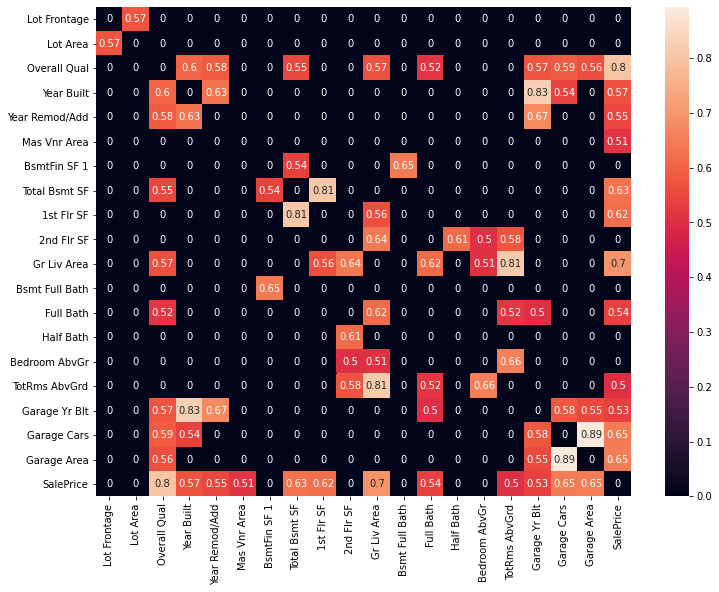

In [8]:
# Visualize colinear features
mask = (high_corr_df > .5) & (high_corr_df < .99)
high_corr_df[mask].fillna(0)
sns.heatmap(high_corr_df[mask].fillna(0), annot=True);

In [9]:
# Drop colinear fetures with lower correlation 
to_drop = ['Lot Area', '1st Flr SF', 'Garage Yr Blt', 'TotRms AbvGrd', 'Garage Cars', 'Year Built', 'Year Remod/Add']
train.drop(columns=to_drop, inplace=True)

---

In [10]:
train.shape

(2051, 72)

In [11]:
train.dtypes

MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
Street           object
Alley            object
                 ...   
Misc Val          int64
Mo Sold           int64
Yr Sold           int64
Sale Type        object
SalePrice         int64
Length: 72, dtype: object

___

## Investigate null values

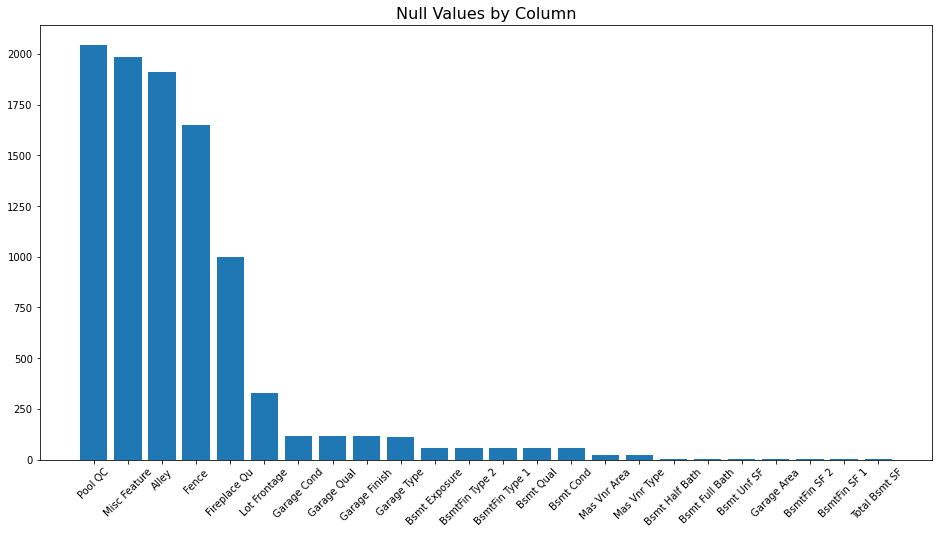

In [12]:
eda.plot_null(train)

**Interpretation:** Many features have null values because the house does not have this featurere, such as a pool, an alley, a garage, etc.  
Some features can be convereted to dummy collumns, others will be imputed to the mean or zero.

In [13]:
def peek_column(col_title):
    print('Unique Values:')
    print(train[col_title].unique())
    print()
    print('Value Counts:')
    print(train[col_title].value_counts())

In [14]:
def peek_columns(cols):
    for col in cols:
        peek_column(col)
        print()

## Convert ordinal features to numerical
* After multiple model iterations, I settled on the below select few features to convert to a numeric scale. 
* Other features negatively impacted the model's predictive power (test R2 and RMSE).

In [15]:
map1 = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
map2 = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}

In [16]:
ordinal_mapping = {
    'Exter Cond': map1,
    'Heating QC': map1,
    'Kitchen Qual': map1,
    'Bsmt Qual': map2,
    'Bsmt Cond': map2,
    'Garage Qual': map2
}

In [17]:
# Credit to Kovacs for this approach
for col, mapping in ordinal_mapping.items():
    train[col] = train[col].map(mapping)

---
## Correct Feature Type

**MS SubClass**

In [18]:
# Ensure no nulls
train['MS SubClass'].fillna(0, inplace=True)

# Make string then convert to dummies
train['MS SubClass'] = train['MS SubClass'].astype(str)

train = pd.get_dummies(train, columns=['MS SubClass']).drop(columns='MS SubClass_20')

---
## Clean null values
* Certain features required a human touch to clean. I handled these first.

## Pool-Related Features

* Only 9 houses have pools
* Convert to "Has Pool"
* Drop other pool related columns

In [19]:
# Engineer 'Has Pool' feature
train['Has Pool'] = train['Pool Area'].map(lambda x: 1 if x >= 1 else 0)
train.drop(columns = ['Pool QC', 'Pool Area'], inplace=True)

In [20]:
train.shape

(2051, 85)

## Misc Feature
* Shed is the only value with high enough frequency to contribute to the model

In [21]:
peek_columns(['Misc Feature'])

Unique Values:
[nan 'Shed' 'TenC' 'Gar2' 'Othr' 'Elev']

Value Counts:
Shed    56
Gar2     4
Othr     3
Elev     1
TenC     1
Name: Misc Feature, dtype: int64



In [22]:
# Convert to 'Has Shed'
train['Has Shed'] = train['Misc Feature'].map(lambda x: 1 if x=='Shed' else 0)
train.drop(columns = ['Misc Feature'], inplace=True)

In [23]:
train.shape

(2051, 85)

## Alley

In [24]:
peek_columns(['Alley'])

Unique Values:
[nan 'Pave' 'Grvl']

Value Counts:
Grvl    85
Pave    55
Name: Alley, dtype: int64



In [25]:
# Add 'Has Alley' and 'Alley Pave' features
train['Has Alley'] = train['Alley'].map(lambda x: 1 if (x == 'Pave') | (x == 'Grvl') else 0)
train['Alley Pave'] = train['Has Alley'].map({1:1, 0:0})
train.drop(columns = ['Alley'], inplace=True)

In [26]:
train.shape

(2051, 86)

## Fence

In [27]:
peek_columns(['Fence'])

Unique Values:
[nan 'MnPrv' 'GdPrv' 'GdWo' 'MnWw']

Value Counts:
MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64



In [28]:
# Dummify Fence feature
train = pd.get_dummies(train, columns=['Fence']).drop(columns='Fence_MnWw')

In [29]:
train.shape

(2051, 88)

## Fireplace Qu

In [30]:
peek_columns(['Fireplace Qu', 'Fireplaces'])

Unique Values:
[nan 'TA' 'Gd' 'Po' 'Ex' 'Fa']

Value Counts:
Gd    523
TA    407
Fa     59
Ex     31
Po     31
Name: Fireplace Qu, dtype: int64

Unique Values:
[0 1 2 4 3]

Value Counts:
0    1000
1     898
2     146
3       6
4       1
Name: Fireplaces, dtype: int64



In [31]:
# Dummify Fireplace Qu feature
train = pd.get_dummies(train, columns=['Fireplace Qu']).drop(columns='Fireplace Qu_Ex')

In [32]:
train.shape

(2051, 91)

## Lot frontage
* Missing values were imputed depending on the type of lot config of the sale.

In [33]:
peek_columns(['Lot Frontage'])

Unique Values:
[ nan  43.  68.  73.  82. 137.  35.  70.  21.  64. 120.  24.  74.  93.
  34.  80.  71.  72. 109.  40. 103. 100.  92.  65.  75.  60.  30.  79.
  41. 105. 107.  81.  36.  63.  32.  94.  44.  50.  48.  67.  88.  83.
  53.  58.  57.  52.  87. 134.  56.  54. 140.  78.  85.  90.  96.  62.
  49.  59. 155.  91.  61.  86. 128.  77.  42.  89.  51.  69.  55. 112.
  76. 125.  98. 113. 102.  22. 122.  84. 119. 118.  66.  95. 108. 195.
 106.  39. 110. 130.  97.  45.  37. 123.  38. 129. 115.  47. 114. 104.
  46. 121. 124. 313. 141. 101.  99. 160. 174.  26. 144. 138. 111.  25.
  33. 200. 150. 117. 153. 116. 135.]

Value Counts:
60.0     179
70.0      96
80.0      94
50.0      90
65.0      71
        ... 
22.0       1
155.0      1
153.0      1
119.0      1
135.0      1
Name: Lot Frontage, Length: 118, dtype: int64



In [34]:
train.loc[train['Lot Frontage'].isna(), ['Bldg Type', 'House Style', 'Lot Config']].head()

,Bldg Type,House Style,Lot Config
0,1Fam,2Story,CulDSac
7,1Fam,1Story,Inside
8,1Fam,1Story,Inside
23,1Fam,1Story,Inside
27,1Fam,1.5Fin,Inside


In [35]:
# Set Lot Frontage = 0 for Lot Config = inside, corner and cul-de-sac
na_lot_frontage = train['Lot Frontage'].isna()
lot_config_to_drop = train['Lot Config'].map(lambda x: 1 if x in ['CulDSac', 'Corner', 'Inside'] else 0)
train.loc[na_lot_frontage & lot_config_to_drop, 'Lot Frontage'] = 0

In [36]:
# Set the remaining missing Lot Frontage values equal to the mean
avg_frontage = train['Lot Frontage'].mean()
train.loc[na_lot_frontage, 'Lot Frontage'] = avg_frontage

## Visualize Distributions

**Sale Price**

In [37]:
rcParams['figure.figsize'] = (20.0, 9.0)

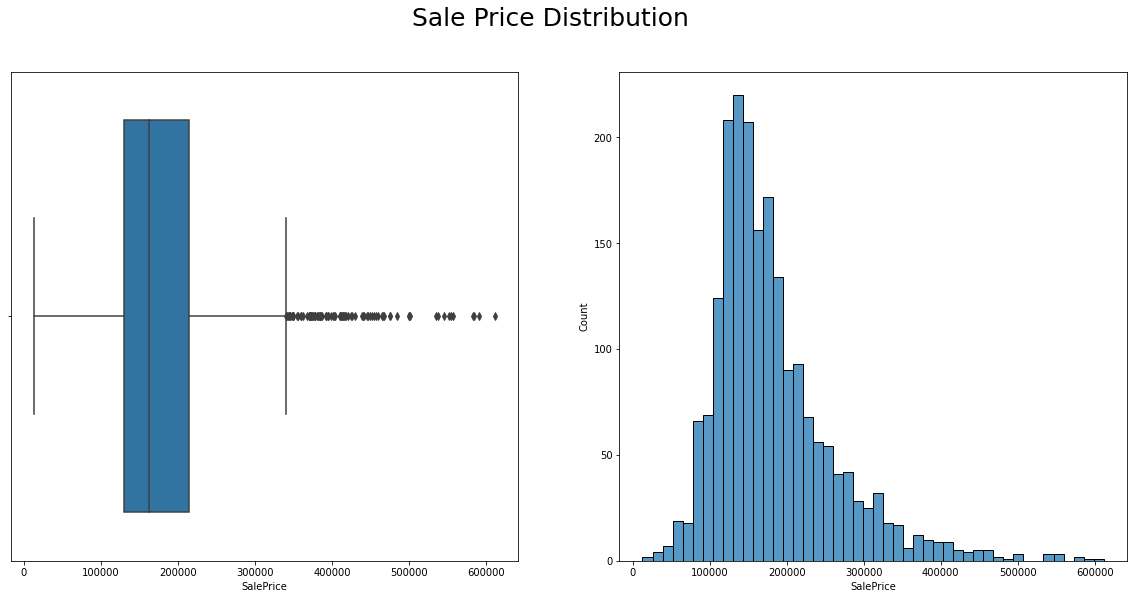

In [38]:
f, ax = plt.subplots(1, 2)
f.suptitle('Sale Price Distribution', size=25)

sns.boxplot(x = train['SalePrice'], ax = ax[0])
sns.histplot(x = 'SalePrice', data = train, ax = ax[1]);

**Interpretation:** Sale price is right skewed. Median price is near \\$180k. Many outliers as sale price increases. Some of these will be dropped, while most will be kept as it is reasonable to assume that this is the true shape of the population distribution, given that a home can not sell for less than \\$0, and realistically will not sell for less than \\$50k.

**Identify possible non-linear realationships**

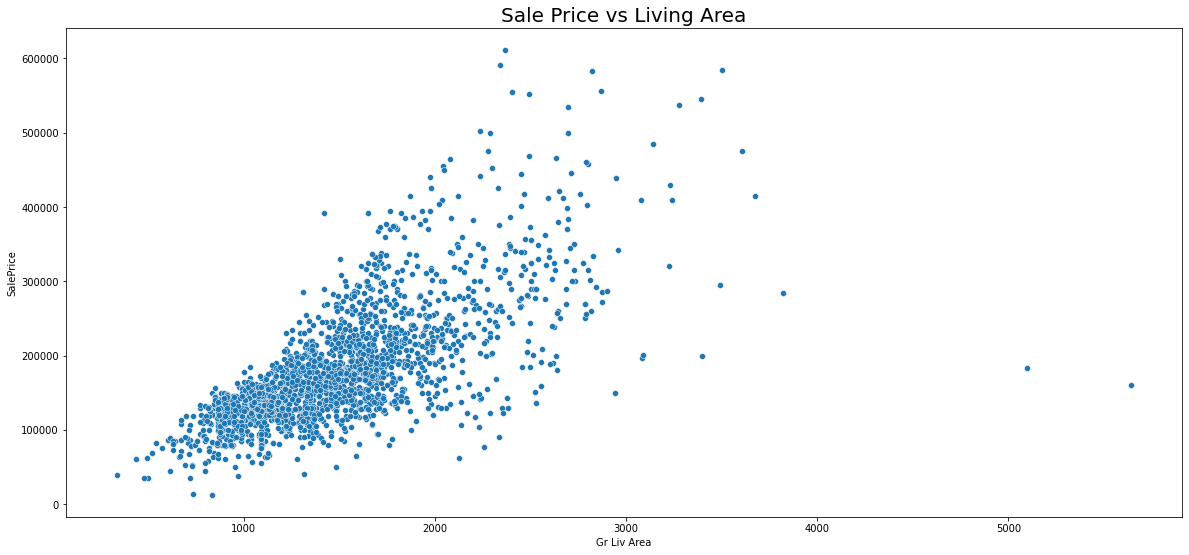

In [39]:
plt.title('Sale Price vs Living Area', size = 20)
sns.scatterplot(x = train['Gr Liv Area'], y = train['SalePrice']);

**Interpretation:** Outliers on the far right of the plot. These values negatively impact model fit quality - drop them. This relationship is not quite linear and may not be best modeled by a linear regression model.

In [40]:
# Drop the two outliers to improve fit quality
less_than_4000 = train['Gr Liv Area'] < 4000
train = train.loc[less_than_4000, :]

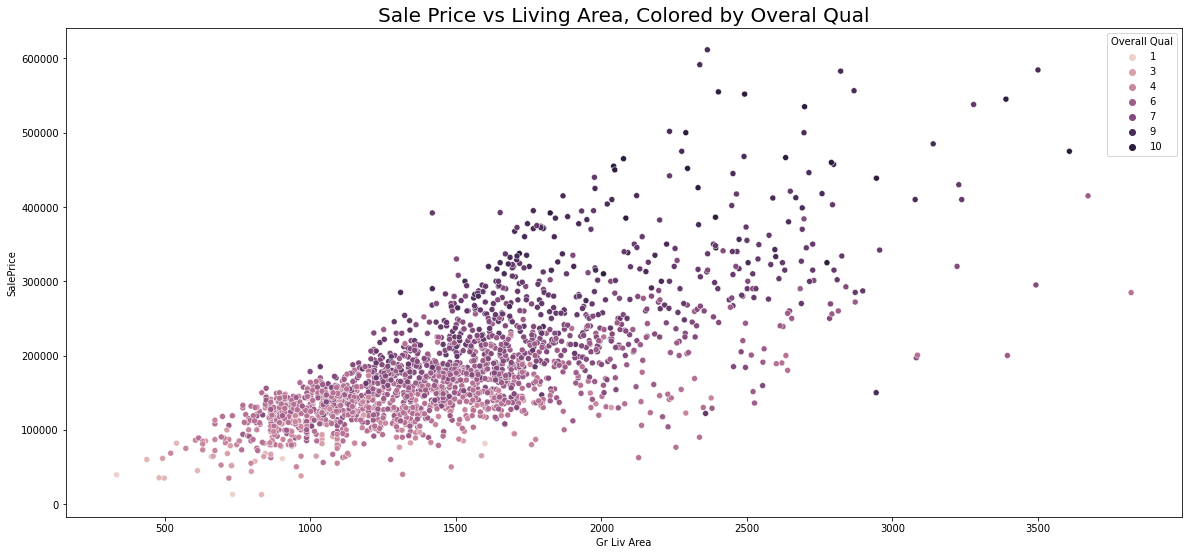

In [41]:
plt.title('Sale Price vs Living Area, Colored by Overal Qual', size = 20)
sns.scatterplot(x = train['Gr Liv Area'], y = train['SalePrice'], hue=train['Overall Qual']);

**Interpretation:** Expensive houses tend to be large and of high quality. These two features make good candidates for interaction terms.

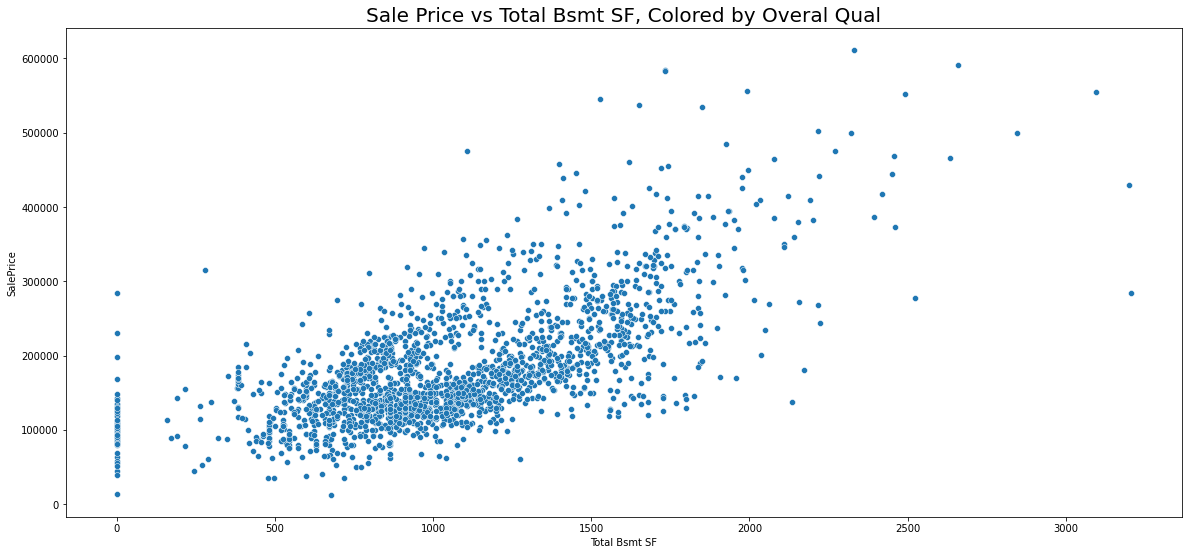

In [42]:
plt.title('Sale Price vs Total Bsmt SF, Colored by Overal Qual', size = 20)
sns.scatterplot(x = train['Total Bsmt SF'], y = train['SalePrice']);

**Interpretation:** Many features related to size have an approximate linear relationship to sale price. Let's check to make sure that the imputed 0's do not effect quality too much.

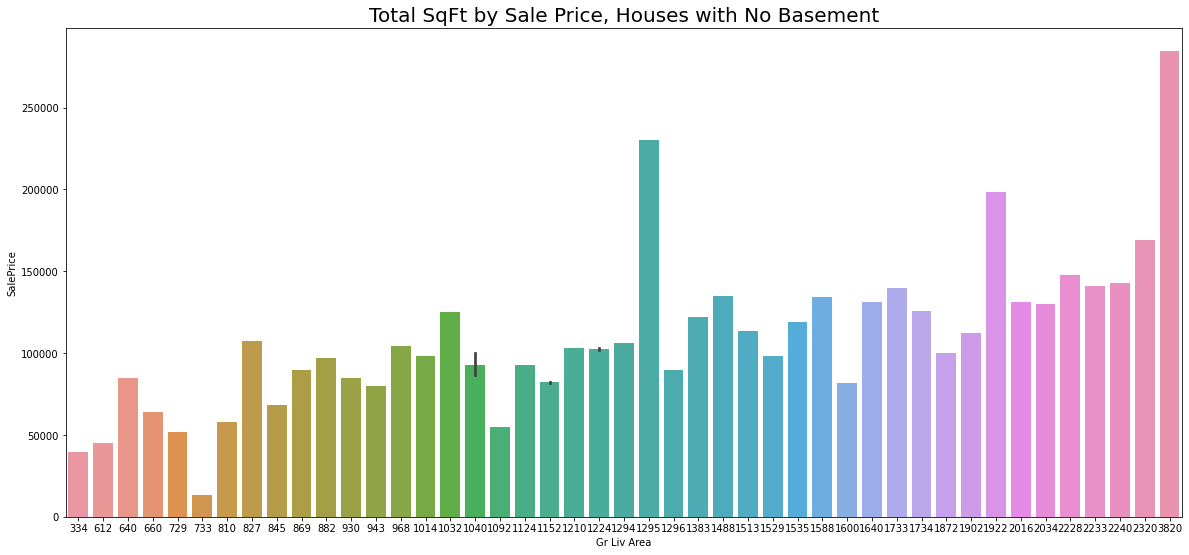

In [43]:
mask = train['Total Bsmt SF'] < 1
train[mask][['SalePrice', 'Gr Liv Area']]
sns.barplot(x = 'Gr Liv Area', y = 'SalePrice', data = train[mask][['SalePrice', 'Gr Liv Area']])
plt.title('Total SqFt by Sale Price, Houses with No Basement', size=20);

**Interpretation:** Relationship is approximately linear. The houses with no basement should still sell higher if the total square footage is large.

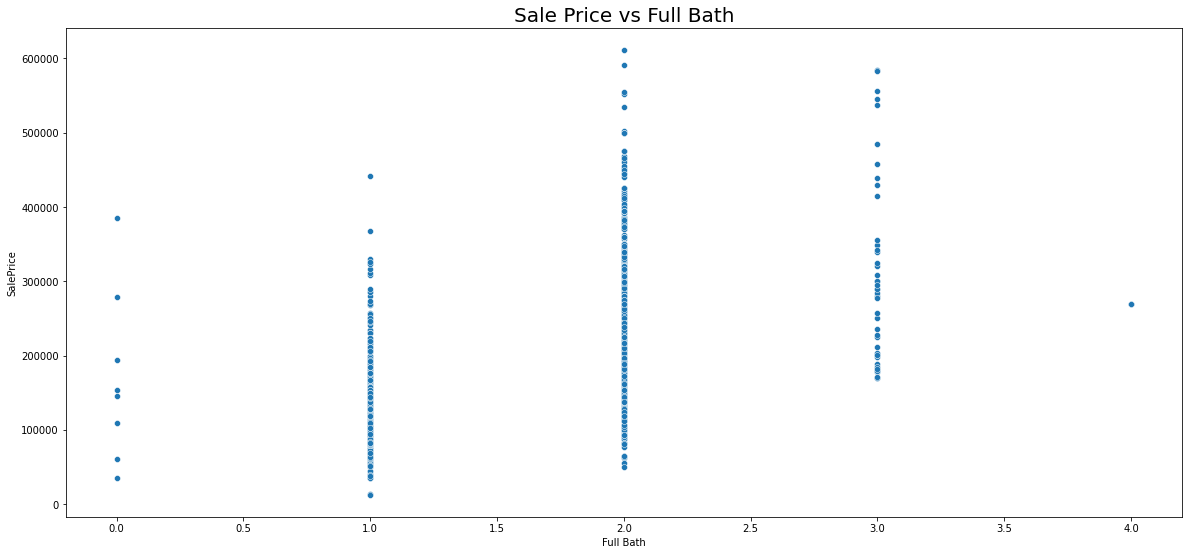

In [44]:
plt.title('Sale Price vs Full Bath', size = 20)
sns.scatterplot(x = train['Full Bath'], y = train['SalePrice']);

**Interpretation:** Each full bath added to a house adds exponential value. Engineer this feature as a polynomial.

## Convert features to binary

In [45]:
# Identify binary columns
for col in train:
    if (len(train[col].unique()) == 2) & (type(train[col][0]) is str):
        print(col)
        print(train[col].unique())

Street
['Pave' 'Grvl']
Central Air
['Y' 'N']


In [46]:
# Central Air
train['Central Air'] = train['Central Air'].map({'Y':1, 'N':0})

In [47]:
# Street feature has all 2049 values. Engineer new column to indicate paved or gravel street
train['Street Pave'] = train['Street'].map({'Pave':1, 'Grvl':0})
train.drop(columns = ['Street'], inplace=True)

In [48]:
train.shape

(2049, 91)

## How did we do?

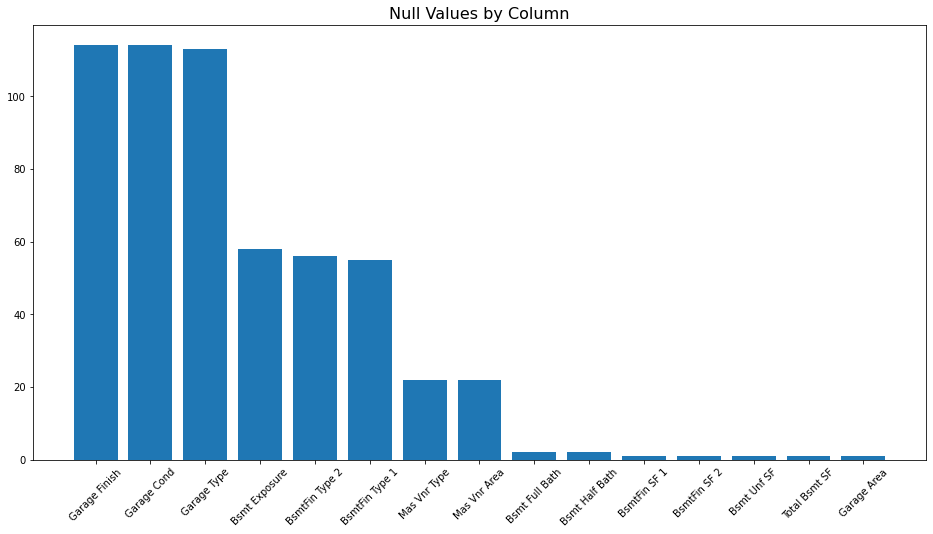

In [49]:
eda.plot_null(train)

**Interpretation:** Mostly categorical features missing values. Dummify these first.

In [50]:
# Aggregate above graph into a dataframe
nulls = eda.investigate_null(train)

In [51]:
# Extract categorical columns
col_types = {col:type(train[col][0]) for col in nulls['column']}
str_cols = [col for col,t in col_types.items() if t is str]

In [52]:
len(str_cols)

7

In [53]:
to_drop = ['Garage Cond_Gd',
           'Garage Finish_Fin',
           'Garage Type_CarPort',
           'Bsmt Exposure_Mn',
           'BsmtFin Type 2_GLQ',
           'BsmtFin Type 1_LwQ',
           'Mas Vnr Type_BrkCmn'
          ]

In [54]:
# Dummify
train = pd.get_dummies(train, columns=str_cols).drop(columns = to_drop)

In [55]:
train = pd.get_dummies(train, columns=['Electrical']).drop(columns = ['Electrical_Mix', 'Electrical_FuseP'])

In [56]:
train.shape

(2049, 113)

---

In [57]:
# Impute 0 to all remaining missing values
train.fillna(0, inplace=True)

In [58]:
# No null values left
eda.investigate_null(train)

,column,null_count


## Converting nominal and ordinal features

In [59]:
# Isolate columns of type string
col_types = {col:type(train[col][0]) for col in train.columns}
str_cols = [col for col,t in col_types.items() if t is str]

In [60]:
train.loc[:, str_cols].head()

,MS Zoning,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,...,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,Heating,Functional,Paved Drive,Sale Type
0,RL,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,...,Gable,CompShg,HdBoard,Plywood,Gd,CBlock,GasA,Typ,Y,WD
1,RL,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,...,Gable,CompShg,VinylSd,VinylSd,Gd,PConc,GasA,Typ,Y,WD
2,RL,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,...,Gable,CompShg,VinylSd,VinylSd,TA,CBlock,GasA,Typ,Y,WD
3,RL,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,...,Gable,CompShg,VinylSd,VinylSd,TA,PConc,GasA,Typ,Y,WD
4,RL,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,...,Gable,CompShg,Wd Sdng,Plywood,TA,PConc,GasA,Typ,N,WD


In [61]:
train = pd.get_dummies(train, columns=str_cols, drop_first=True).reset_index(drop=True)

In [62]:
train.shape

(2049, 231)

## Heatmap of feature correlation to target

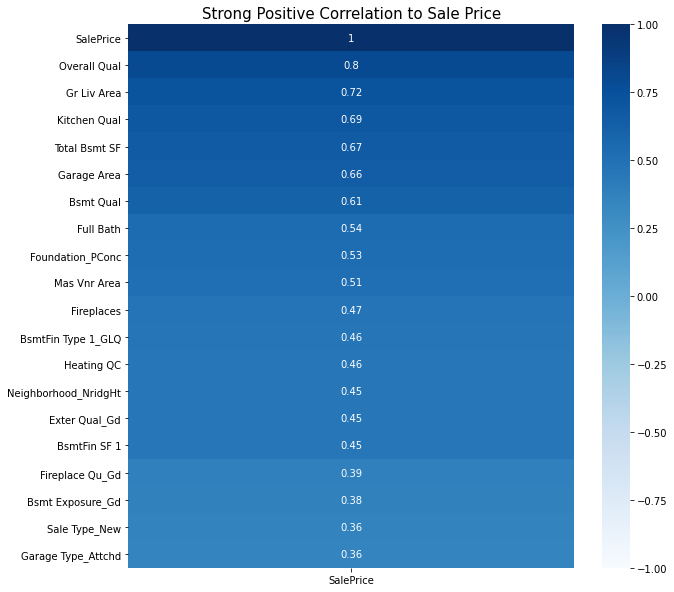

In [63]:
plt.figure(figsize=(10,10))
plt.title('Strong Positive Correlation to Sale Price', size=15)
sns.heatmap(train.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).head(20), cmap='Blues', vmin=-1, vmax=1, annot=True);

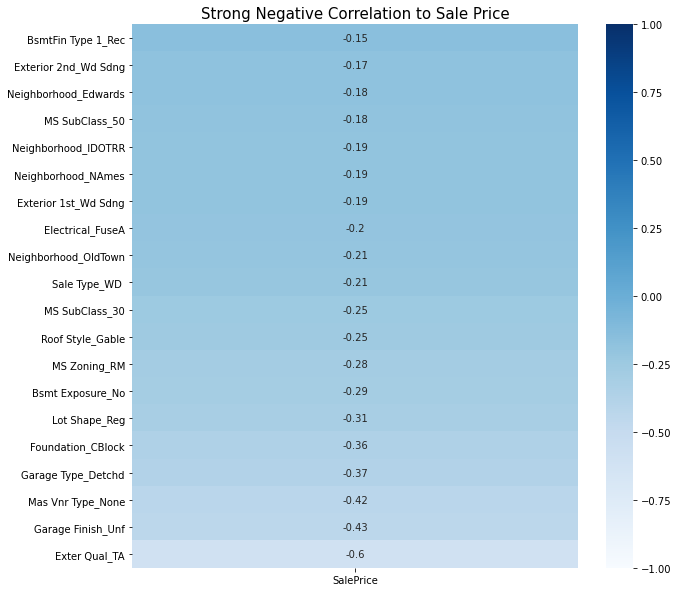

In [64]:
plt.figure(figsize=(10,10))
plt.title('Strong Negative Correlation to Sale Price', size=15)
sns.heatmap(train.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).tail(20), cmap='Blues', vmin=-1, vmax=1, annot=True);

**Interpretation:** Overall quality, total square footage and kitchen quality have the strongest positive correlations to sale price. Many of the top 10 highly correleated features have significant colinearity, but I will keep them as I believe they will improve the fit of the model.  
An average exterior quality, unfinished garage and no masonry vaneer have the strongest negative correlations to sale price.

## Save clean dataset

In [65]:
train.to_csv('../datasets/clean/train_clean.csv', index=False)